In [ ]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup


final = pd.DataFrame()
for j in range(1, 350):
    webpage = requests.get(f'https://markets.businessinsider.com/news/meta-stock?p={j}&').text
    soup = BeautifulSoup(webpage, 'lxml')
    company = soup.find_all('div', class_="latest-news__story")
    news = []
    date = []

    for i in company:
        try:
            news.append(i.find('a', class_="news-link").text.strip())
        except:
            news.append(np.nan)

        try:
            date.append(i.find(class_="latest-news__date").text.strip())
        except:
            date.append(np.nan)

    df = pd.DataFrame({
        'news': news,
        'date': date,
    })

    final = pd.concat([final, df], ignore_index=True)


final['date'] = final['date'].apply(lambda x: '0' if any(c in x for c in ['s', 'm', 'h']) else x)

final['date'] = final['date'].str.replace('d', '').str.replace(',', '').astype(int)

final = final[final['date'] <= 2500]

from datetime import datetime, timedelta

df = pd.DataFrame(final)

def convert_to_actual_date(relative_days):
    yesterday = datetime.today() - timedelta(days=1)
    actual_date = yesterday - timedelta(days=relative_days)
    return actual_date.date()

df['date'] = df['date'].apply(convert_to_actual_date)

df = df.groupby('date')['news'].apply(lambda x: ' '.join(x)).reset_index()

df = df.set_index('date')

#extracting stock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go

meta = yf.Ticker("META")
history =meta.history(period="5y")

history.index = history.index.date

history.index.name = 'date'

df2 = pd.DataFrame(history)

result = pd.merge(df, df2, on='date', how='left')


final_rows = []
for i in range(len(result)):
        if i > 0 and pd.isna(result['Open'].iloc[i]):
            final_rows[-1]['news'] += ' ' + result['news'].iloc[i]
        else:
            final_rows.append(result.iloc[i])

final_df = pd.DataFrame(final_rows)

data = final_df.copy()
data.reset_index(inplace=True)

# Convert 'Close' prices to price movements (binary classification)
data['Price_Up'] = (data['Close'].shift(-1) > data['Close']).astype(int)


data1 = data.dropna()


In [ ]:
data1.shape

(1016, 10)

In [ ]:
!pip install vaderSentiment
import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

data['Subjectivity'] = data1['news'].apply(getSubjectivity)
data['Polarity'] = data1['news'].apply(getPolarity)

sia = SentimentIntensityAnalyzer()

data1[['compound', 'negative', 'positive', 'neutral']] = data1['news'].apply(
    lambda x: pd.Series(sia.polarity_scores(x))
)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)

# Apply preprocessing to 'news' column
data1['processed_news'] = data1['news'].apply(preprocess_text)

X_text = data1['processed_news']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(X_text)

tfidf_df = pd.DataFrame(X.toarray(), index=data1.index)

data1 = data1.join(tfidf_df.add_suffix('_tfidf'))


In [ ]:
data1=data1.drop(['Dividends','Stock Splits'],axis=1)

data1['Price_Up'] = (data1['Close'].shift(-1) > data1['Close']).astype(int)

y=np.array(data1['Price_Up'])

x = data1.drop(['Price_Up', 'news', 'processed_news', 'index'], axis=1).values

chosen model is Linear Discriminant Analysis
Accuracy: 0.46229508196721314
              precision    recall  f1-score   support

           0       0.44      0.58      0.50       142
           1       0.50      0.36      0.42       163

    accuracy                           0.46       305
   macro avg       0.47      0.47      0.46       305
weighted avg       0.47      0.46      0.46       305



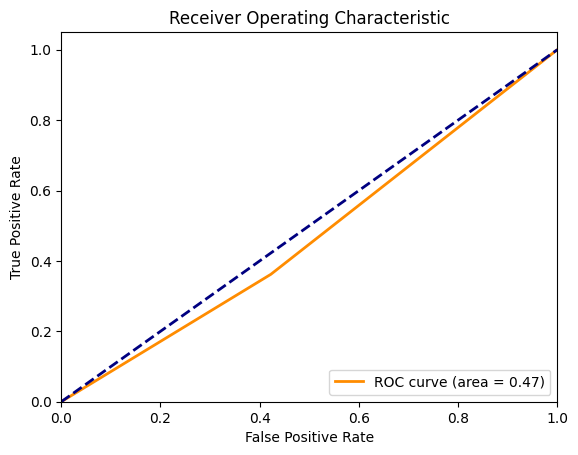

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

n = len(x)
split_point = int(n * 0.7)  # Determine the split point for 70%

x_train = x[:split_point]  # First 70% of the data
x_test = x[split_point:]   # Last 30% of the data

y_train = y[:split_point]  # First 70% of the target values
y_test = y[split_point:]   # Last 30% of the target values

model=LinearDiscriminantAnalysis()
model.fit(x_train,y_train)
lda_predictions=model.predict(x_test)
lda_accuracy = accuracy_score(y_test, lda_predictions)

from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100 )
rf_model.fit(x_train, y_train)
rf_predictions = rf_model.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)


accuracies = [lda_accuracy, rf_accuracy]
best_model_index = accuracies.index(max(accuracies))

# Store predictions based on the model with the highest accuracy
if best_model_index == 0:
    predictions = lda_predictions
    best_model_name = "Linear Discriminant Analysis"
else :
    predictions = rf_predictions
    best_model_name = "Random Forest"

print("chosen model is", best_model_name)
print("Accuracy:", accuracies[best_model_index])
print(classification_report(y_test, predictions))


fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
data2=data1.copy()
data2.reset_index(inplace=True)
data2 = data2.rename(columns={'index': 'date'})


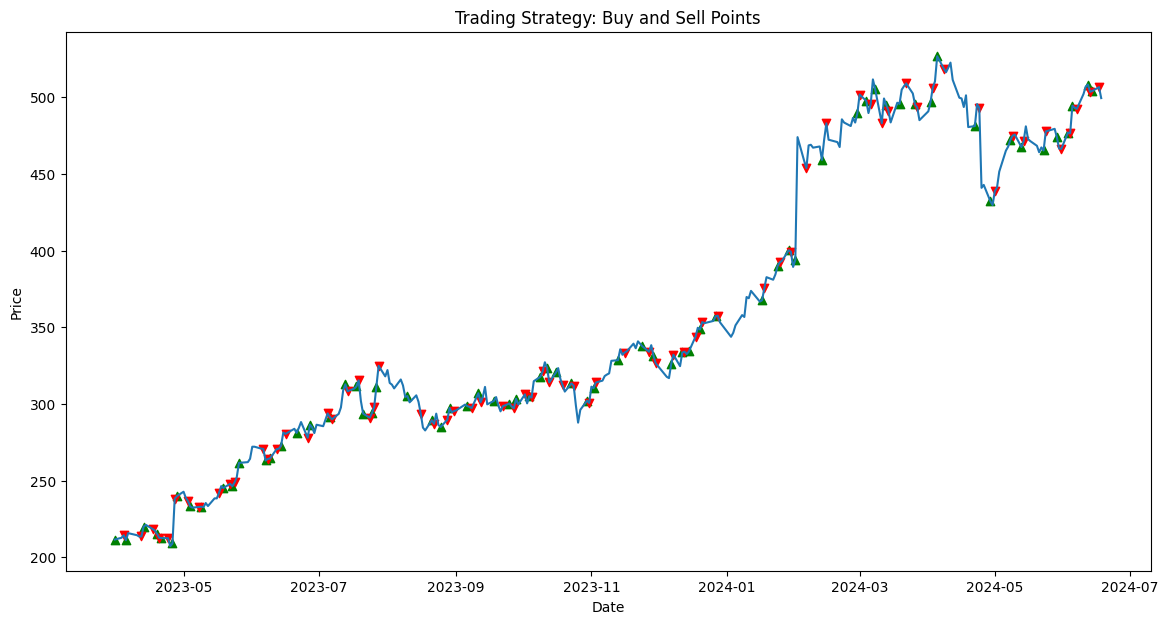

Final Portfolio Value: 168452.91995239258
Sharpe Ratio: 2.125582138172344
Maximum Drawdown: -0.1842643965285229
Number of Trades Executed: 140
Win Ratio: 0.2642857142857143
Annual Returns: 0.7760091528398546
Annual Standard Deviation: 0.3603761713478164


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def trading_strategy(prediction1, price_close):
    portfolio = 100000  # Starting with $100,000
    shares = 0
    buy_points = []
    sell_points = []

    for date, prediction in prediction1.items():
        price = price_close[date]
        if prediction == 1 and (portfolio>price):
            shares += portfolio // price
            portfolio %= price
            buy_points.append((date, price))
        elif prediction == 0 and shares > 0:
            portfolio += shares * price
            shares = 0
            sell_points.append((date, price))

    final_value = portfolio + shares * price_close[list(price_close.keys())[-1]]

    return final_value, buy_points, sell_points

prediction1 = dict(zip(data2['date'][split_point:],predictions))
doc = dict(zip(data2['date'][split_point:],data2['Close'][split_point:]))
final_value, buy_points, sell_points = trading_strategy(prediction1, doc)

# Execute trading strategy
final_value, buy_points, sell_points = trading_strategy(prediction1, doc)

# Plotting buy and sell points
dates = list(doc.keys())
prices = list(doc.values())

plt.figure(figsize=(14, 7))
plt.plot(dates, prices, label='Stock Price')
for point in buy_points:
    plt.scatter(point[0], point[1], color='green', marker='^', label='Buy')
for point in sell_points:
    plt.scatter(point[0], point[1], color='red', marker='v', label='Sell')
plt.title('Trading Strategy: Buy and Sell Points')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Calculate additional metrics
daily_returns = np.diff(prices) / prices[:-1]

# Annualize returns and standard deviation (assuming 252 trading days in a year)
avg_daily_return = np.mean(daily_returns)
std_dev_daily_return = np.std(daily_returns)
annual_return = avg_daily_return * 252
annual_std_dev = std_dev_daily_return * np.sqrt(252)

# Risk-free rate assumption (e.g., 1% per annum)
risk_free_rate = 0.01

# Calculate Sharpe ratio
sharpe_ratio = (annual_return - risk_free_rate) / annual_std_dev

# Calculate maximum drawdown
cumulative_returns = np.cumprod(1 + daily_returns) - 1
peak = np.maximum.accumulate(cumulative_returns)
drawdown = (cumulative_returns - peak) / (peak + 1)
max_drawdown = np.min(drawdown)

# Calculate number of trades executed
num_trades = len(buy_points) + len(sell_points)

# Calculate win ratio
winning_trades = 0
for buy_point, sell_point in zip(buy_points, sell_points):
    if sell_point[1] > buy_point[1]:
        winning_trades += 1

win_ratio = winning_trades / num_trades if num_trades > 0 else 0

# Print final metrics
print("Final Portfolio Value:", final_value)
print("Sharpe Ratio:", sharpe_ratio)
print("Maximum Drawdown:", max_drawdown)
print("Number of Trades Executed:", num_trades)
print("Win Ratio:", win_ratio)
print("Annual Returns:", annual_return)
print("Annual Standard Deviation:", annual_std_dev)


In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import requests
from bs4 import BeautifulSoup


final = pd.DataFrame()
for j in range(1, 250):
    webpage = requests.get(f'https://markets.businessinsider.com/news/amzn-stock?p={j}&').text
    soup = BeautifulSoup(webpage, 'lxml')
    company = soup.find_all('div', class_="latest-news__story")
    news = []
    date = []

    for i in company:
        try:
            news.append(i.find('a', class_="news-link").text.strip())
        except:
            news.append(np.nan)

        try:
            date.append(i.find(class_="latest-news__date").text.strip())
        except:
            date.append(np.nan)

    df = pd.DataFrame({
        'news': news,
        'date': date,
    })

    final = pd.concat([final, df], ignore_index=True)


final['date'] = final['date'].apply(lambda x: '0' if any(c in x for c in ['s', 'm', 'h']) else x)

final['date'] = final['date'].str.replace('d', '').str.replace(',', '').astype(int)

final = final[final['date'] <= 1500]

from datetime import datetime, timedelta

df = pd.DataFrame(final)

def convert_to_actual_date(relative_days):
    yesterday = datetime.today() - timedelta(days=1)
    actual_date = yesterday - timedelta(days=relative_days)
    return actual_date.date()

df['date'] = df['date'].apply(convert_to_actual_date)

df = df.groupby('date')['news'].apply(lambda x: ' '.join(x)).reset_index()

df = df.set_index('date')


#extracting stock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go

amazon = yf.Ticker("AMZN")
history =amazon.history(period="5y")

history.index = history.index.date

history.index.name = 'date'

df2 = pd.DataFrame(history)

result = pd.merge(df, df2, on='date', how='left')


final_rows = []
for i in range(len(result)):
        if i > 0 and pd.isna(result['Open'].iloc[i]):
            final_rows[-1]['news'] += ' ' + result['news'].iloc[i]
        else:
            final_rows.append(result.iloc[i])

final_df = pd.DataFrame(final_rows)

data = final_df.copy()
data.reset_index(inplace=True)

# Convert 'Close' prices to price movements (binary classification)
data['Price_Up'] = (data['Close'].shift(-1) > data['Close']).astype(int)

data1 = data.dropna()


<ipython-input-38-8fda95df5bc3>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_rows[-1]['news'] += ' ' + result['news'].iloc[i]


In [ ]:
data1.shape

(1011, 10)

In [ ]:
!pip install vaderSentiment
import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

data['Subjectivity'] = data1['news'].apply(getSubjectivity)
data['Polarity'] = data1['news'].apply(getPolarity)

sia = SentimentIntensityAnalyzer()

data1[['compound', 'negative', 'positive', 'neutral']] = data1['news'].apply(
    lambda x: pd.Series(sia.polarity_scores(x))
)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)

# Apply preprocessing to 'news' column
data1['processed_news'] = data1['news'].apply(preprocess_text)

X_text = data1['processed_news']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(X_text)

# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(X.toarray(), index=data1.index)

# Merge the TF-IDF DataFrame with the original DataFrame
data1 = data1.join(tfidf_df.add_suffix('_tfidf'))

In [ ]:
data1=data1.drop(['Dividends','Stock Splits'],axis=1)
data1['Price_Up'] = (data1['Close'].shift(-1) > data1['Close']).astype(int)

y=np.array(data1['Price_Up'])

x = data1.drop(['Price_Up', 'news', 'processed_news', 'index'], axis=1).values

chosen model is Random Forest
Accuracy: 0.5197368421052632
              precision    recall  f1-score   support

           0       0.49      0.62      0.55       141
           1       0.57      0.43      0.49       163

    accuracy                           0.52       304
   macro avg       0.53      0.53      0.52       304
weighted avg       0.53      0.52      0.52       304

Annual Returns: 0.7760091528398546
Annual Standard Deviation: 0.3603761713478164


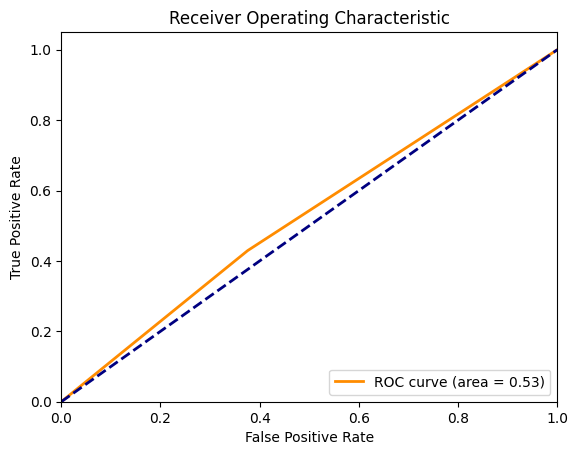

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

n = len(x)
split_point = int(n * 0.7)

x_train = x[:split_point]
x_test = x[split_point:]

y_train = y[:split_point]
y_test = y[split_point:]

model=LinearDiscriminantAnalysis()
model.fit(x_train,y_train)
lda_predictions=model.predict(x_test)
lda_accuracy = accuracy_score(y_test, lda_predictions)

from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100 )
rf_model.fit(x_train, y_train)
rf_predictions = rf_model.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

accuracies = [lda_accuracy, rf_accuracy]
best_model_index = accuracies.index(max(accuracies))



# Store predictions based on the model with the highest accuracy
if best_model_index == 0:
    predictions = lda_predictions
    best_model_name = "Linear Discriminant Analysis"
else:
    predictions = rf_predictions
    best_model_name = "Random Forest"

print("chosen model is", best_model_name)
print("Accuracy:", accuracies[best_model_index])
print(classification_report(y_test, predictions))
print("Annual Returns:", annual_return)
print("Annual Standard Deviation:", annual_std_dev)

fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
data2=data1.copy()
data2.reset_index(inplace=True)
data2 = data2.rename(columns={'index': 'date'})

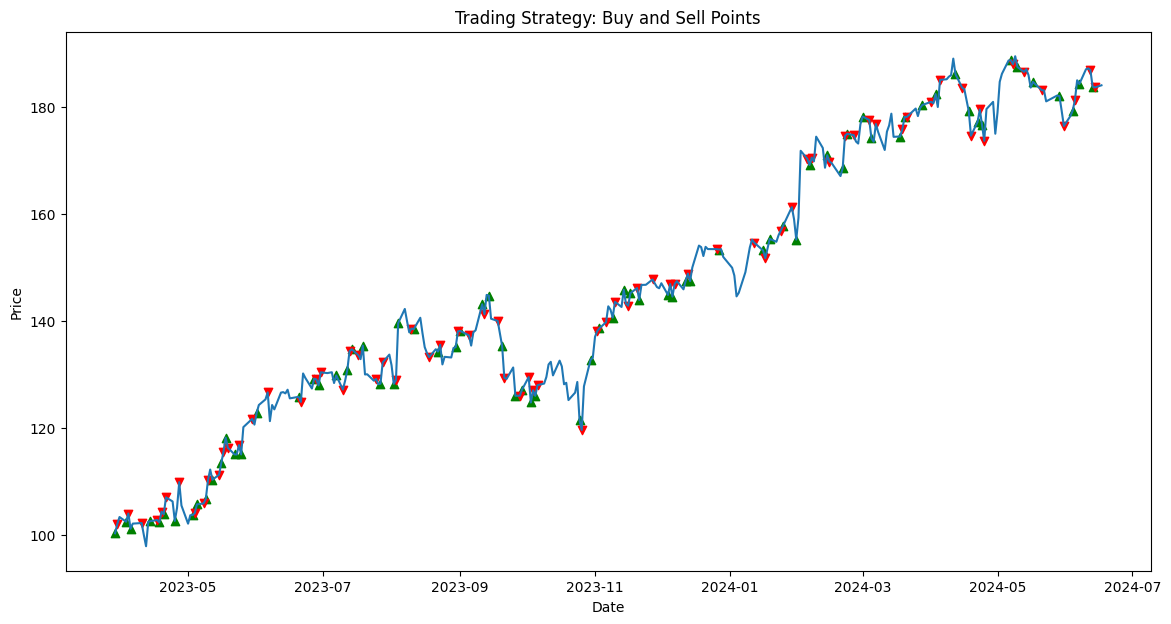

Final Portfolio Value: 168571.2007369995
Sharpe Ratio: 1.8721894973671918
Maximum Drawdown: -0.17452540796322266
Number of Trades Executed: 148
Win Ratio: 0.3108108108108108
Annual Returns: 0.5466113191015817
Annual Standard Deviation: 0.28662233169035684


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def trading_strategy(prediction1, price_close):
    portfolio = 100000  # Starting with $100,000
    shares = 0
    buy_points = []
    sell_points = []

    for date, prediction in prediction1.items():
        price = price_close[date]
        if prediction == 1 and (portfolio>price):
            shares += portfolio // price
            portfolio %= price
            buy_points.append((date, price))
        elif prediction == 0 and shares > 0:
            portfolio += shares * price
            shares = 0
            sell_points.append((date, price))

    final_value = portfolio + shares * price_close[list(price_close.keys())[-1]]

    return final_value, buy_points, sell_points

prediction1 = dict(zip(data2['date'][split_point:],predictions))
doc = dict(zip(data2['date'][split_point:],data2['Close'][split_point:]))
final_value, buy_points, sell_points = trading_strategy(prediction1, doc)

# Execute trading strategy
final_value, buy_points, sell_points = trading_strategy(prediction1, doc)

# Plotting buy and sell points
dates = list(doc.keys())
prices = list(doc.values())

plt.figure(figsize=(14, 7))
plt.plot(dates, prices, label='Stock Price')
for point in buy_points:
    plt.scatter(point[0], point[1], color='green', marker='^', label='Buy')
for point in sell_points:
    plt.scatter(point[0], point[1], color='red', marker='v', label='Sell')
plt.title('Trading Strategy: Buy and Sell Points')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Calculate additional metrics

# Calculate daily returns
daily_returns = np.diff(prices) / prices[:-1]

# Annualize returns and standard deviation (assuming 252 trading days in a year)
avg_daily_return = np.mean(daily_returns)
std_dev_daily_return = np.std(daily_returns)
annual_return = avg_daily_return * 252
annual_std_dev = std_dev_daily_return * np.sqrt(252)

# Risk-free rate assumption (e.g., 1% per annum)
risk_free_rate = 0.01

# Calculate Sharpe ratio
sharpe_ratio = (annual_return - risk_free_rate) / annual_std_dev

# Calculate maximum drawdown
cumulative_returns = np.cumprod(1 + daily_returns) - 1
peak = np.maximum.accumulate(cumulative_returns)
drawdown = (cumulative_returns - peak) / (peak + 1)
max_drawdown = np.min(drawdown)

# Calculate number of trades executed
num_trades = len(buy_points) + len(sell_points)

# Calculate win ratio
winning_trades = 0
for buy_point, sell_point in zip(buy_points, sell_points):
    if sell_point[1] > buy_point[1]:
        winning_trades += 1

win_ratio = winning_trades / num_trades if num_trades > 0 else 0

# Print final metrics
print("Final Portfolio Value:", final_value)
print("Sharpe Ratio:", sharpe_ratio)
print("Maximum Drawdown:", max_drawdown)
print("Number of Trades Executed:", num_trades)
print("Win Ratio:", win_ratio)
print("Annual Returns:", annual_return)
print("Annual Standard Deviation:", annual_std_dev)


In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import requests
from bs4 import BeautifulSoup


final = pd.DataFrame()
for j in range(1, 250):
    webpage = requests.get(f'https://markets.businessinsider.com/news/goog-stock?p={j}&').text
    soup = BeautifulSoup(webpage, 'lxml')
    company = soup.find_all('div', class_="latest-news__story")
    news = []
    date = []

    for i in company:
        try:
            news.append(i.find('a', class_="news-link").text.strip())
        except:
            news.append(np.nan)

        try:
            date.append(i.find(class_="latest-news__date").text.strip())
        except:
            date.append(np.nan)

    df = pd.DataFrame({
        'news': news,
        'date': date,
    })

    final = pd.concat([final, df], ignore_index=True)


final['date'] = final['date'].apply(lambda x: '0' if any(c in x for c in ['s', 'm', 'h']) else x)

final['date'] = final['date'].str.replace('d', '').str.replace(',', '').astype(int)

final = final[final['date'] <= 1500]

from datetime import datetime, timedelta

df = pd.DataFrame(final)

def convert_to_actual_date(relative_days):
    yesterday = datetime.today() - timedelta(days=1)
    actual_date = yesterday - timedelta(days=relative_days)
    return actual_date.date()

df['date'] = df['date'].apply(convert_to_actual_date)

df = df.groupby('date')['news'].apply(lambda x: ' '.join(x)).reset_index()

df = df.set_index('date')


#extracting stock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go

google = yf.Ticker("GOOGL")
history =google.history(period="5y")

history.index = history.index.date

history.index.name = 'date'

df2 = pd.DataFrame(history)

result = pd.merge(df, df2, on='date', how='left')


final_rows = []
for i in range(len(result)):
        if i > 0 and pd.isna(result['Open'].iloc[i]):
            final_rows[-1]['news'] += ' ' + result['news'].iloc[i]
        else:
            final_rows.append(result.iloc[i])

final_df = pd.DataFrame(final_rows)

data = final_df.copy()
data.reset_index(inplace=True)

# Convert 'Close' prices to price movements (binary classification)
data['Price_Up'] = (data['Close'].shift(-1) > data['Close']).astype(int)

data1 = data.dropna()


<ipython-input-47-5f734760c63a>:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_rows[-1]['news'] += ' ' + result['news'].iloc[i]


In [ ]:
data1.shape

(942, 10)

In [ ]:
!pip install vaderSentiment
import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

data['Subjectivity'] = data1['news'].apply(getSubjectivity)
data['Polarity'] = data1['news'].apply(getPolarity)

sia = SentimentIntensityAnalyzer()

data1[['compound', 'negative', 'positive', 'neutral']] = data1['news'].apply(
    lambda x: pd.Series(sia.polarity_scores(x))
)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)

# Apply preprocessing to 'news' column
data1['processed_news'] = data1['news'].apply(preprocess_text)

# Define features and target
X_text = data1['processed_news']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(X_text)

tfidf_df = pd.DataFrame(X.toarray(), index=data1.index)

data1 = data1.join(tfidf_df.add_suffix('_tfidf'))

In [ ]:
data1=data1.drop(['Dividends','Stock Splits'],axis=1)
data1['Price_Up'] = (data1['Close'].shift(-1) > data1['Close']).astype(int)

y=np.array(data1['Price_Up'])

x = data1.drop(['Price_Up', 'news', 'processed_news', 'index'], axis=1).values

chosen model is Random Forest
Accuracy: 0.49823321554770317
              precision    recall  f1-score   support

           0       0.43      0.60      0.50       118
           1       0.60      0.42      0.50       165

    accuracy                           0.50       283
   macro avg       0.51      0.51      0.50       283
weighted avg       0.53      0.50      0.50       283



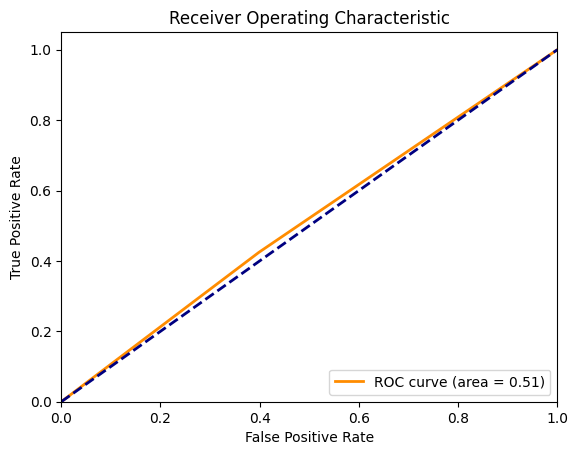

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc


n = len(x)
split_point = int(n * 0.7)

x_train = x[:split_point]
x_test = x[split_point:]

y_train = y[:split_point]
y_test = y[split_point:]

model=LinearDiscriminantAnalysis()
model.fit(x_train,y_train)
lda_predictions=model.predict(x_test)
lda_accuracy = accuracy_score(y_test, lda_predictions)

from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100 )
rf_model.fit(x_train, y_train)
rf_predictions = rf_model.predict(x_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)


accuracies = [lda_accuracy, rf_accuracy]
best_model_index = accuracies.index(max(accuracies))

# Store predictions based on the model with the highest accuracy
if best_model_index == 0:
    predictions = lda_predictions
    best_model_name = "Linear Discriminant Analysis"
else:
    predictions = rf_predictions
    best_model_name = "Random Forest"
print("chosen model is", best_model_name)
print("Accuracy:", accuracies[best_model_index])
print(classification_report(y_test, predictions))


fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
data2=data1.copy()
data2.reset_index(inplace=True)
data2 = data2.rename(columns={'index': 'date'})


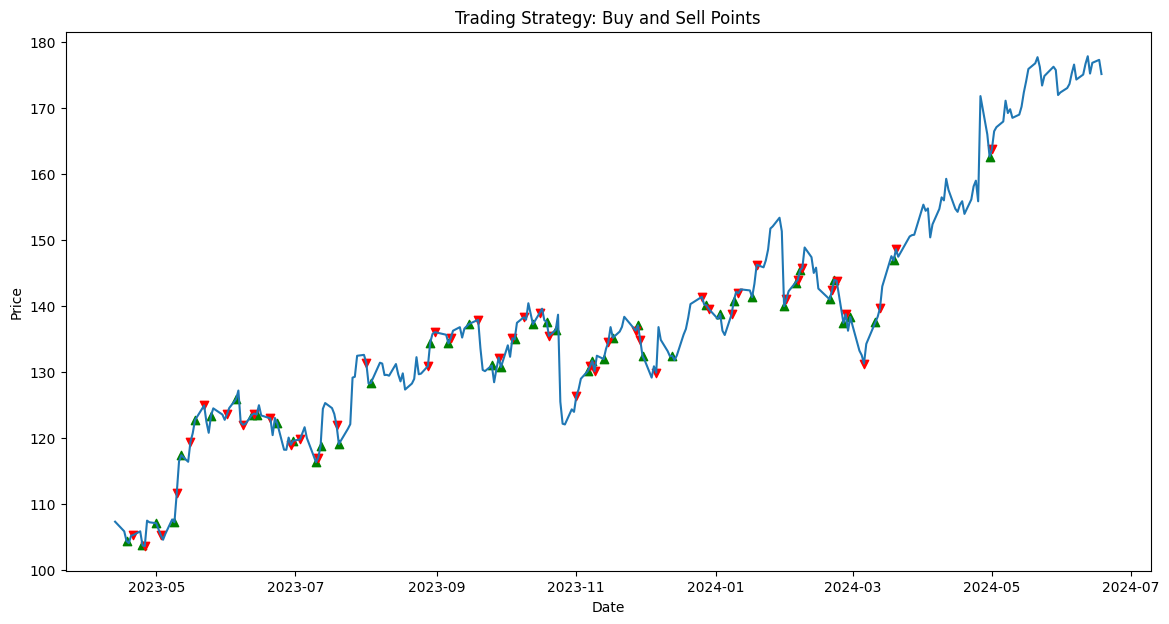

Final Portfolio Value: 130713.73432159424
Sharpe Ratio: 1.6697474872324858
Maximum Drawdown: -0.14402972345823406
Number of Trades Executed: 92
Win Ratio: 0.34782608695652173
Annual Returns: 0.4770588540187545
Annual Standard Deviation: 0.27971825535900563


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def trading_strategy(prediction1, price_close):
    portfolio = 100000  # Starting with $100,000
    shares = 0
    buy_points = []
    sell_points = []

    for date, prediction in prediction1.items():
        price = price_close[date]
        if prediction == 1 and (portfolio>price):
            shares += portfolio // price
            portfolio %= price
            buy_points.append((date, price))
        elif prediction == 0 and shares > 0:
            portfolio += shares * price
            shares = 0
            sell_points.append((date, price))

    final_value = portfolio + shares * price_close[list(price_close.keys())[-1]]

    return final_value, buy_points, sell_points

prediction1 = dict(zip(data2['date'][split_point:],predictions))
doc = dict(zip(data2['date'][split_point:],data2['Close'][split_point:]))
final_value, buy_points, sell_points = trading_strategy(prediction1, doc)

# Execute trading strategy
final_value, buy_points, sell_points = trading_strategy(prediction1, doc)

# Plotting buy and sell points
dates = list(doc.keys())
prices = list(doc.values())

plt.figure(figsize=(14, 7))
plt.plot(dates, prices, label='Stock Price')
for point in buy_points:
    plt.scatter(point[0], point[1], color='green', marker='^', label='Buy')
for point in sell_points:
    plt.scatter(point[0], point[1], color='red', marker='v', label='Sell')
plt.title('Trading Strategy: Buy and Sell Points')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Calculate additional metrics

# Calculate daily returns
daily_returns = np.diff(prices) / prices[:-1]

# Annualize returns and standard deviation (assuming 252 trading days in a year)
avg_daily_return = np.mean(daily_returns)
std_dev_daily_return = np.std(daily_returns)
annual_return = avg_daily_return * 252
annual_std_dev = std_dev_daily_return * np.sqrt(252)

# Risk-free rate assumption (e.g., 1% per annum)
risk_free_rate = 0.01

# Calculate Sharpe ratio
sharpe_ratio = (annual_return - risk_free_rate) / annual_std_dev

# Calculate maximum drawdown
cumulative_returns = np.cumprod(1 + daily_returns) - 1
peak = np.maximum.accumulate(cumulative_returns)
drawdown = (cumulative_returns - peak) / (peak + 1)
max_drawdown = np.min(drawdown)

# Calculate number of trades executed
num_trades = len(buy_points) + len(sell_points)

# Calculate win ratio
winning_trades = 0
for buy_point, sell_point in zip(buy_points, sell_points):
    if sell_point[1] > buy_point[1]:
        winning_trades += 1

win_ratio = winning_trades / num_trades if num_trades > 0 else 0

# Print final metrics
print("Final Portfolio Value:", final_value)
print("Sharpe Ratio:", sharpe_ratio)
print("Maximum Drawdown:", max_drawdown)
print("Number of Trades Executed:", num_trades)
print("Win Ratio:", win_ratio)
print("Annual Returns:", annual_return)
print("Annual Standard Deviation:", annual_std_dev)
